In [111]:
import pandas as pd
import numpy as np

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics

import re

from random import sample

import gensim

# 1 Get the corpora

In [2]:
mis_df = pd.read_csv("tweets_small.csv")
mis_df_small = mis_df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
mis_df_small.head()

,Datetime,Tweet Id,Text,User,User_location,Place,Coordinates,Keyword
0,2021-06-15 17:05:20+00:00,1404847502331990018,“bitch what r u doing out there without me” ht...,_lindssss,NJ,NaN,NaN,bitch
1,2021-06-15 09:48:15+00:00,1404737509549121536,"What's worse, that grin of his yawns about as ...",catullusbot,Ancient Rome,NaN,NaN,cunt
2,2021-01-20 12:53:06+00:00,1351875400692101123,Omg yo my future wife prolly giving a nigga th...,Coopavelli_,443,NaN,NaN,pussy
3,2021-01-20 05:29:38+00:00,1351763797065740289,Any bitch I bring out gonna have the time of h...,FalonRonae,Why? We never linking.,NaN,NaN,bitch
4,2021-06-15 03:46:15+00:00,1404646407231852545,Chrissy Teigen has always been that unfunny re...,authenticduke,All Over Los Angeles,NaN,NaN,bitch ass


In [9]:
import collections
collections.Counter(mis_df_small['Keyword'])

Counter({'bitch': 17101,
         'cunt': 978,
         'pussy': 3655,
         'bitch ass': 861,
         'hoe': 2797,
         'boob': 1429,
         'fucker': 920,
         'slut': 818,
         'dumb fuck': 245,
         'whore': 1035,
         'mothafucka': 17,
         'assfuck': 29,
         'cock suck': 65,
         'cumslut': 50})

## 2 Preprocessing

https://catriscode.com/2021/05/01/tweets-cleaning-with-python/

The steps:
1. Removing hashtags and mentions
2. Removing links
3. Removing punctuations
4. Filtering non-alphanumeric characters

In [28]:
processed_text = []
for t in mis_df_small['Text']:
    temp = re.sub("@[A-Za-z0-9_]+","", t)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r"http\S+", "", temp)
    temp = re.sub(r"www.\S+", "", temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    processed_text.append(temp)
mis_df_small['cleaned_text'] = processed_text


# 2 TF-IDF with `sklearn`

In [29]:
#initialize
misTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
#train
misTFVects = misTFVectorizer.fit_transform(mis_df_small['cleaned_text'])
misTFVects.shape

(30000, 7550)

# 3 K-means

## 3.1 Select the cluster number

In [30]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(misTFVects.toarray())
reduced_data = pca.transform(misTFVects.toarray())

In [5]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

In [31]:
X = misTFVects.toarray()
X.shape

(30000, 7550)

It's too large and the `plotSilhouette function would cost a lot of time. So here we'll use only a 10% sample of it.

In [32]:
idx = np.random.randint(30000, size=3000)


In [33]:
X_small = X[idx,:]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


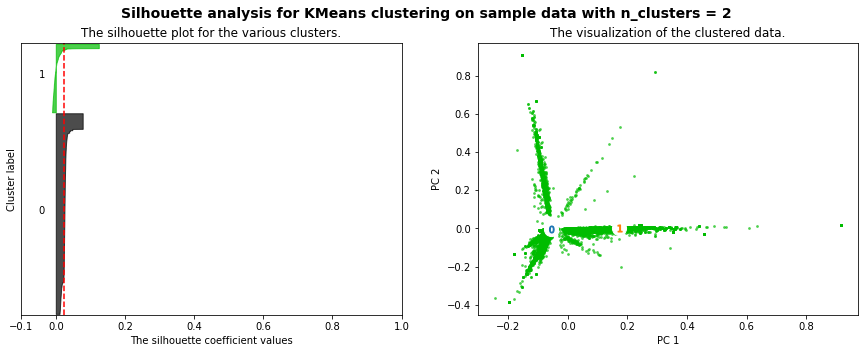

For n_clusters = 2, The average silhouette_score is : 0.023


In [34]:

plotSilhouette(2, X_small)

There seems to be around 4 rays. So let's try a cluster number of 4.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


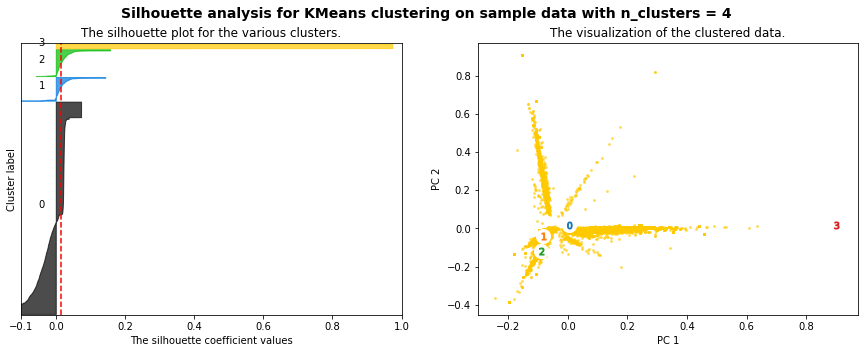

For n_clusters = 4, The average silhouette_score is : 0.015


In [35]:
plotSilhouette(4, X_small)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


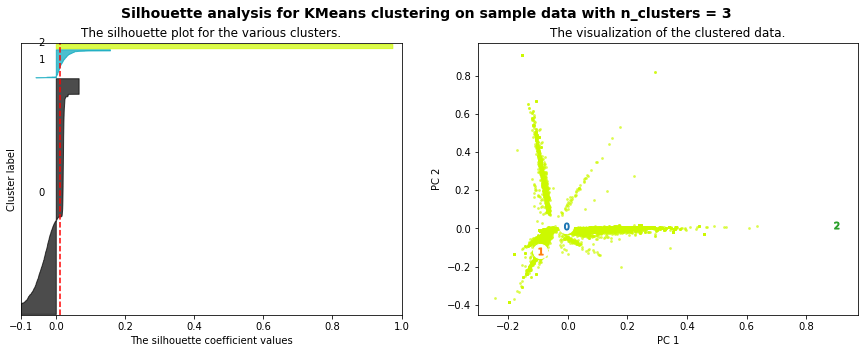

For n_clusters = 3, The average silhouette_score is : 0.013


In [36]:
plotSilhouette(3, X_small)

Although the clusters seem to be seperate from each other now, the silhoutte_score become lower.

What about a even larger number?

Now we have three clusters huddling together...I'll just pick the cluster number to be 8.

In [37]:
N_CLUSTER=2

In [38]:
km = sklearn.cluster.KMeans(n_clusters=N_CLUSTER, init='k-means++')
km.fit(misTFVects)
mis_df_small['kmeans_predictions'] = km.labels_

In [39]:
terms = misTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(N_CLUSTER):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 bitch
 bitches
 pussy
 like
 itch
 ass
 just
 hoes
 hoe
 don
Cluster 1:
 bitch
 like
 fr
 friend
 gone
 ow
 continue
 ou
 thought
 fascist


C:\Users\liqiu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 3.1 Visualize it

In [40]:
colors = {0: 'red',
         1: 'blue'}

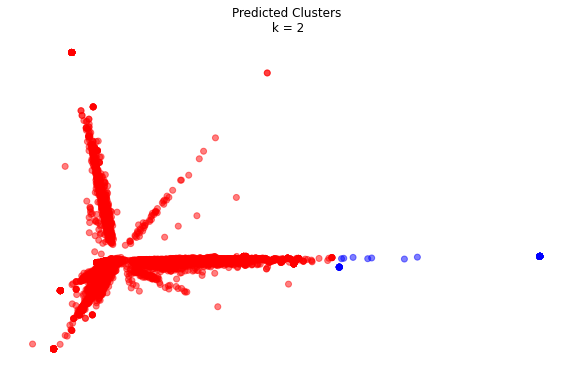

In [42]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=mis_df_small['kmeans_predictions'].map(colors), alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 2')
plt.show()

Most tweets here are pretty "close". And only a small set of tweets were abondaned by Cluster 0. Let's take a look at what they are.

In [43]:
collections.Counter(mis_df_small['kmeans_predictions'])

Counter({0: 29537, 1: 463})

In [68]:
index_set = list(mis_df_small[mis_df_small['kmeans_predictions']==0].index)
n = sample(index_set,1)[0]
mis_df_small['Text'][n]

'@24Kobe_fan8 @Ganon_Dank @KEEMSTAR you clearly haven’t seen the whole thing. her mom was hitting her and saying “you’re lucky i’m pro life” calling her a bitch and screaming “fuck you”. it’s not ok to say to your child no matter what the circumstances.'

In [69]:
index_set = list(mis_df_small[mis_df_small['kmeans_predictions']==1].index)
n = sample(index_set,1)[0]
mis_df_small['Text'][n]

'@bunnyIuvrs me bitch'

In [70]:
index_set = list(mis_df_small[mis_df_small['kmeans_predictions']==1].index)
n = sample(index_set,1)[0]
mis_df_small['Text'][n]

'@girlie_tehe @0r1hs_priv bitch that’s u'

In [71]:
index_set = list(mis_df_small[mis_df_small['kmeans_predictions']==1].index)
n = sample(index_set,1)[0]
mis_df_small['Text'][n]

'bitch me too! https://t.co/sa3OI37JDC'

I tried to list some examples. And it seems to me that the small Cluster 1 is just a cluster of super short sentences.

# 4 Topic modeling

In [87]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [107]:
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner", "lemmatizer"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized
    
def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, MAX_LEN=1500000):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        list_tmp = []
        for elem in word_list:
            list_tmp.append(elem)
        word_list = ' '.join(list_tmp) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(w.lemma_)
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(w.text.strip())

    return normalized

In [143]:
mis_df_smaller = mis_df_small.sample(n=10000)

In [144]:
corpora = ""
for sentence in mis_df_smaller['cleaned_text']:
    corpora = corpora + sentence

In [145]:
#Apply our functions
tokenized_text = word_tokenize(corpora)

In [146]:
normalized_tokens = normalizeTokens(tokenized_text)

C:\Users\liqiu\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [149]:
normalized_tokens

['better',
 'pozole',
 'year',
 'bitch',
 'itches',
 'extra',
 'poor',
 'end',
 'eally',
 'ree',
 'country',
 'fuckers',
 'll',
 'celebrate',
 'like',
 'love',
 'ones',
 'choose',
 'hope',
 'mindless',
 'sheep',
 'don',
 't',
 'oscow',
 'inority',
 'itch',
 'bitch',
 'faces',
 'indsay',
 'trip',
 'bitch',
 'flights',
 'stairs',
 'hesitation',
 'pussy',
 'eater',
 'ls',
 'hat',
 's',
 'rude',
 'uh',
 'bitch',
 'supposed',
 'omewhere',
 'world',
 'rn',
 'chopped',
 'amp',
 'edited',
 'navy',
 'videos',
 'leak',
 'sitting',
 'watching',
 'thing',
 'play',
 'omeone',
 'remote',
 'view',
 'fucker',
 'et',
 'exposed',
 'bitch',
 'popular',
 'cunt',
 't',
 's',
 'cause',
 'niggas',
 'told',
 'niggas',
 'old',
 'bitches',
 'm',
 'toooo',
 'pussy',
 'watch',
 'lol',
 'good',
 'luck',
 'sisbitch',
 'needa',
 'myspace',
 'naked',
 'home',
 'bitch',
 'lmaoo',
 'bitches',
 'want',
 'ass',
 'ate',
 't',
 'quesadilla',
 'right',
 'idc',
 'bad',
 'argument',
 'bitch',
 'nt',
 'leave',
 'miami',
 'hoes

In [147]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
reduced_tokens = dropMissing(normalized_tokens, misTFVectorizer.vocabulary_.keys())

In [156]:
split_tokens = [x.split() for x in reduced_tokens]

In [153]:
dictionary = gensim.corpora.Dictionary(split_tokens)

In [157]:
corpus = [dictionary.doc2bow(text) for text in split_tokens]

In [158]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

In [159]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [162]:
sen1Bow = dictionary.doc2bow(reduced_tokens)
sen1lda = senlda[sen1Bow]
topics = [senlda[dictionary.doc2bow(l)] for l in split_tokens]

In [163]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(topics) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(topics):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

In [169]:
ldaDF = pd.DataFrame({
        'n': list(range(len(topics))),
        'topics' : topics
    })
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [170]:
ldaDF

,n,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,"[(0, 0.048728112), (1, 0.54989713), (2, 0.0849...",0.048728,0.549897,0.084938,0.042940,0.044832,0.045388,0.045549,0.044182,0.045750,0.047795
1,1,"[(0, 0.048728418), (1, 0.056085818), (2, 0.084...",0.048728,0.056086,0.084939,0.042941,0.044832,0.045388,0.045550,0.044183,0.539558,0.047796
2,2,"[(0, 0.048727885), (1, 0.056085203), (2, 0.578...",0.048728,0.056085,0.578752,0.042940,0.044831,0.045388,0.045549,0.044182,0.045749,0.047795
3,3,"[(0, 0.04872811), (1, 0.05608546), (2, 0.08493...",0.048728,0.056085,0.084938,0.042940,0.044832,0.045388,0.045549,0.044182,0.045750,0.541607
4,4,"[(0, 0.5424676), (1, 0.056094307), (2, 0.08495...",0.542468,0.056094,0.084952,0.042947,0.044839,0.045395,0.045557,0.044189,0.045757,0.047803
...,...,...,...,...,...,...,...,...,...,...,...,...
62285,62285,"[(0, 0.09625222), (1, 0.11078996), (2, 0.16791...",0.096252,0.110790,0.167910,0.084818,0.088554,0.089654,0.089972,0.087272,0.090368,0.094409
62286,62286,"[(0, 0.04872826), (1, 0.05608564), (2, 0.08493...",0.048728,0.056086,0.084939,0.042940,0.538642,0.045388,0.045549,0.044182,0.045750,0.047795
62287,62287,"[(0, 0.09624446), (1, 0.11078129), (2, 0.16797...",0.096244,0.110781,0.167977,0.084811,0.088547,0.089647,0.089965,0.087265,0.090361,0.094402
62288,62288,"[(0, 0.04872827), (1, 0.056085642), (2, 0.0849...",0.048728,0.056086,0.084939,0.042940,0.044832,0.539198,0.045549,0.044182,0.045750,0.047795


In [171]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
#ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
#ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.048728,0.549897,0.084938,0.042940,0.044832,0.045388,0.045549,0.044182,0.045750,0.047795
1,0.048728,0.056086,0.084939,0.042941,0.044832,0.045388,0.045550,0.044183,0.539558,0.047796
2,0.048728,0.056085,0.578752,0.042940,0.044831,0.045388,0.045549,0.044182,0.045749,0.047795
3,0.048728,0.056085,0.084938,0.042940,0.044832,0.045388,0.045549,0.044182,0.045750,0.541607
4,0.542468,0.056094,0.084952,0.042947,0.044839,0.045395,0.045557,0.044189,0.045757,0.047803
5,0.048732,0.549863,0.084945,0.042944,0.044835,0.045392,0.045553,0.044186,0.045753,0.047799
6,0.048729,0.056086,0.084939,0.042941,0.044832,0.045389,0.045550,0.044183,0.539555,0.047796
7,0.048731,0.056089,0.084943,0.042943,0.044834,0.045391,0.539334,0.044185,0.045752,0.047798
8,0.048737,0.056095,0.084953,0.042948,0.044839,0.045396,0.045557,0.044190,0.539481,0.047804
9,0.542526,0.056087,0.084941,0.042942,0.044833,0.045390,0.045551,0.044184,0.045751,0.047797


In [172]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,don,pussy,bitch,hat,know,shit,hoes,hoe,ou,like
1,nt,fuck,bitches,slut,want,amp,bad,love,whore,time
2,wanna,boobs,ass,need,fucking,little,good,let,work,hate
3,tell,going,itch,lol,fucker,people,nigga,big,gone,ain
4,dumb,cunt,got,right,called,man,cause,day,ike,nd
5,dick,said,ll,eat,fuckers,new,ve,hy,money,stop
6,boob,thing,think,face,damn,cunts,tryna,house,away,itches
7,ow,getting,look,wtf,ur,yo,job,girls,niggas,mad
8,start,ot,girl,kids,woman,way,come,listen,probably,play
9,boy,better,baby,went,et,oobs,looking,uck,calling,head
